In [77]:
import pandas as pd
from geopy.distance import geodesic
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta

import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
#from lazypredict.Supervised import LazyClassifier
from sklearn.utils import resample

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [ ]:
# Lazy Predict
#clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
#models,predictions = clf.fit(X_train, X_test, y_train, y_test)

#print(models)

In [4]:
faults = pd.read_pickle('data/on_faults.pkl')

In [5]:
faults.columns

Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'eventDescription',
       'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake',
       'ecuSource', 'spn', 'fmi', 'active', 'activeTransitionCount',
       'EquipmentID', 'MCTNumber', 'Latitude', 'Longitude',
       'LocationTimeStamp', 'EventDate', 'EventTime', 'LocationDate',
       'LocationTime', 'AcceleratorPedal', 'BarometricPressure',
       'CruiseControlActive', 'CruiseControlSetSpeed', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus',
       'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure', 'dist_A', 'dist_B', 'dist_C'],
      dtype='object')

In [6]:
# separate time delta and date
# create season columns via date column
# filter out duplicates
# find avg time between time-deltas
# set observation window for avg time between time-deltas

Clean data: created time-delta columns and season columns.

In [7]:
faults['event_date'] = faults['EventTimeStamp'].dt.date

In [8]:
faults['event_time'] = faults['EventTimeStamp'].dt.time

In [9]:
faults['event_year'] = faults['EventTimeStamp'].dt.year

In [10]:
faults['event_month'] = faults['EventTimeStamp'].dt.month

In [11]:
faults['event_day'] = faults['EventTimeStamp'].dt.day

In [12]:
faults

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,...,Throttle,TurboBoostPressure,dist_A,dist_B,dist_C,event_date,event_time,event_year,event_month,event_day
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,...,NaN,0,216.606433,246.704143,200.193116,2015-02-21,10:47:13,2015,2,21
1,2,990360,2015-02-21 11:34:34,NaN,unknown,unknown,unknown,unknown,11,629,...,NaN,NaN,216.606433,246.704143,200.193116,2015-02-21,11:34:34,2015,2,21
2,3,990364,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,1807,...,NaN,NaN,376.288759,408.660612,437.341259,2015-02-21,11:35:31,2015,2,21
3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,1807,...,NaN,NaN,376.273067,408.644871,437.328302,2015-02-21,11:35:33,2015,2,21
4,5,990416,2015-02-21 11:39:41,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,...,NaN,NaN,231.836616,255.977579,377.629116,2015-02-21,11:39:41,2015,2,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057456,1248454,123904424,2020-03-06 14:00:26,Low (Severity Low) Catalyst Tank Level,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,...,NaN,NaN,76.930838,108.249961,163.506360,2020-03-06,14:00:26,2020,3,6
1057457,1248455,123905139,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,...,73.2,7.83,410.888391,404.516415,243.920462,2020-03-06,14:04:23,2020,3,6
1057458,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,...,100,6.96,141.618964,117.628771,156.616286,2020-03-06,14:13:38,2020,3,6
1057459,1248457,123906113,2020-03-06 14:14:13,Low (Severity Medium) Engine Coolant Level,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,...,100,1.74,95.038294,74.155986,145.072305,2020-03-06,14:14:13,2020,3,6


In [13]:
faults.loc[(faults['event_month'] <= 3), 'season'] = 'winter'

In [14]:
faults.loc[(faults['event_month'] == 12), 'season'] = 'winter'

In [15]:
faults.loc[(faults['event_month'] <= 5) & (faults['event_month']  >= 3), 'season'] = 'spring' 

In [16]:
faults.loc[(faults['event_month'] <= 8) & (faults['event_month']  >= 6), 'season'] = 'summer' 

In [17]:
faults.loc[(faults['event_month'] <= 11) & (faults['event_month']  >= 9), 'season'] = 'fall' 

In [18]:
faults.loc[~faults.duplicated(['EquipmentID', 'event_date'], keep = 'first')]#[['EquipmentID', 'EventDate']]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,...,TurboBoostPressure,dist_A,dist_B,dist_C,event_date,event_time,event_year,event_month,event_day,season
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,...,0,216.606433,246.704143,200.193116,2015-02-21,10:47:13,2015,2,21,winter
2,3,990364,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,1807,...,NaN,376.288759,408.660612,437.341259,2015-02-21,11:35:31,2015,2,21,winter
4,5,990416,2015-02-21 11:39:41,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,...,NaN,231.836616,255.977579,377.629116,2015-02-21,11:39:41,2015,2,21,winter
5,6,990431,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,111,...,6.67,593.183546,583.476307,771.563146,2015-02-21,11:40:22,2015,2,21,winter
6,7,990439,2015-02-21 11:40:52,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,...,20.59,57.661421,90.640855,187.904738,2015-02-21,11:40:52,2015,2,21,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057446,1248443,123896482,2020-03-06 13:11:24,NaN,04358814*06027020*051718174436*09401683*G1*BDR*,79903052,6X1u13D1500000000,CMMNS,0,4339,...,NaN,455.424327,475.511948,313.955420,2020-03-06,13:11:24,2020,3,6,spring
1057454,1248452,123901805,2020-03-06 13:42:48,Low (Severity Medium) Engine Coolant Level,04358814*06030918*051718174436*09401683*G1*BDR*,79904453,6X1u13D1500000000,CMMNS,0,111,...,0.58,554.653921,569.483398,389.053864,2020-03-06,13:42:48,2020,3,6,spring
1057456,1248454,123904424,2020-03-06 14:00:26,Low (Severity Low) Catalyst Tank Level,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,...,NaN,76.930838,108.249961,163.506360,2020-03-06,14:00:26,2020,3,6,spring
1057458,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,...,6.96,141.618964,117.628771,156.616286,2020-03-06,14:13:38,2020,3,6,spring


In [ ]:
full_derates = faults.loc[faults['spn'] == 5246]

In [18]:
faults['winter_occurrence'] = full_derates.apply(lambda row: 1 if 'winter' in row['season'] else 0, axis=1)
faults['spring_occurrence'] = full_derates.apply(lambda row: 1 if 'spring' in row['season'] else 0, axis=1)
faults['summer_occurrence'] = full_derates.apply(lambda row: 1 if 'summer' in row['season'] else 0, axis=1)
faults['fall_occurrence'] = full_derates.apply(lambda row: 1 if 'fall' in row['season'] else 0, axis=1)

NameError: name 'full_derates' is not defined

In [ ]:
full_derates_seasons = faults.fillna(0)

In [ ]:
full_derates_seasons.to_csv('data/full_derates_seasons.csv')

In [19]:
full_derates_seasons = pd.read_csv('data/full_derates_seasons.csv', low_memory=False)

In [20]:
full_derates_seasons

,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,event_date,event_time,event_year,event_month,event_day,season,winter_occurrence,spring_occurrence,summer_occurrence,fall_occurrence
0,0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,...,2015-02-21,10:47:13,2015,2,21,winter,0.0,0.0,0.0,0.0
1,1,2,990360,2015-02-21 11:34:34,0,unknown,unknown,unknown,unknown,11,...,2015-02-21,11:34:34,2015,2,21,winter,0.0,0.0,0.0,0.0
2,2,3,990364,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,...,2015-02-21,11:35:31,2015,2,21,winter,0.0,0.0,0.0,0.0
3,3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,unknown,unknown,unknown,unknown,11,...,2015-02-21,11:35:33,2015,2,21,winter,0.0,0.0,0.0,0.0
4,4,5,990416,2015-02-21 11:39:41,0,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,...,2015-02-21,11:39:41,2015,2,21,winter,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057456,1057456,1248454,123904424,2020-03-06 14:00:26,Low (Severity Low) Catalyst Tank Level,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,...,2020-03-06,14:00:26,2020,3,6,spring,0.0,0.0,0.0,0.0
1057457,1057457,1248455,123905139,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,...,2020-03-06,14:04:23,2020,3,6,spring,0.0,0.0,0.0,0.0
1057458,1057458,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,...,2020-03-06,14:13:38,2020,3,6,spring,0.0,0.0,0.0,0.0
1057459,1057459,1248457,123906113,2020-03-06 14:14:13,Low (Severity Medium) Engine Coolant Level,04384413*22544852*090619141107*60701756*G1*BGT*,0,0,0,0,...,2020-03-06,14:14:13,2020,3,6,spring,0.0,0.0,0.0,0.0


In [ ]:
full_derates_seasons = full_derates_seasons[['spn', 'AcceleratorPedal','EngineRpm','EquipmentID', 'EngineOilTemperature',
                                             'EngineLoad', 'EngineOilPressure','winter_occurrence', 'spring_occurrence',
                                            'summer_occurrence', 'fall_occurrence', 'fmi']]

# Convert the columns to numeric data types
full_derates_seasons = full_derates_seasons.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with 0 and convert to integers
full_derates_seasons = full_derates_seasons.fillna(0).astype(int)

In [21]:
full_derates_seasons = full_derates_seasons.drop(columns = 'Unnamed: 0')

In [22]:
full_derates_seasons['event_time_diff'] = pd.to_datetime(full_derates_seasons['event_time'], format='%H:%M:%S')

In [23]:
full_derates_seasons = full_derates_seasons.set_index('EventTimeStamp').sort_index(ascending = False)

In [24]:
full_derates_seasons

,RecordID,ESS_Id,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,...,event_time,event_year,event_month,event_day,season,winter_occurrence,spring_occurrence,summer_occurrence,fall_occurrence,event_time_diff
EventTimeStamp,,,,,,,,,,,,,,,,,,,,,
2020-03-06 14:15:34,1248458,123906131,Low (Severity Medium) Engine Coolant Level,04384413*22544852*090619141107*60701756*G1*BGT*,0,0,0,0,111,18,...,14:15:34,2020,3,6,spring,0.0,0.0,0.0,0.0,1900-01-01 14:15:34
2020-03-06 14:14:13,1248457,123906113,Low (Severity Medium) Engine Coolant Level,04384413*22544852*090619141107*60701756*G1*BGT*,0,0,0,0,111,18,...,14:14:13,2020,3,6,spring,0.0,0.0,0.0,0.0,1900-01-01 14:14:13
2020-03-06 14:13:38,1248456,123905996,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,...,14:13:38,2020,3,6,spring,0.0,0.0,0.0,0.0,1900-01-01 14:13:38
2020-03-06 14:04:23,1248455,123905139,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,...,14:04:23,2020,3,6,spring,0.0,0.0,0.0,0.0,1900-01-01 14:04:23
2020-03-06 14:00:26,1248454,123904424,Low (Severity Low) Catalyst Tank Level,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,...,14:00:26,2020,3,6,spring,0.0,0.0,0.0,0.0,1900-01-01 14:00:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-21 11:18:20,20,990544,High Voltage (Fuel Level),unknown,unknown,unknown,unknown,49,96,3,...,11:18:20,2015,2,21,winter,0.0,0.0,0.0,0.0,1900-01-01 11:18:20
2015-02-21 11:18:20,21,990545,High Voltage (Left Fuel Level Sensor),unknown,unknown,unknown,unknown,49,829,3,...,11:18:20,2015,2,21,winter,0.0,0.0,0.0,0.0,1900-01-01 11:18:20
2015-02-21 11:14:38,15,990494,Incorrect Data Brake Signal Sensor 1,unknown,unknown,unknown,unknown,11,1067,2,...,11:14:38,2015,2,21,winter,0.0,0.0,0.0,0.0,1900-01-01 11:14:38


In [25]:
full_derates_seasons_dum = pd.get_dummies(data=full_derates_seasons.loc[:, ['spn',
                                                                            'EquipmentID'
                                                                           ]], columns=['spn']) 
                                                                          
                                                                            
                                                                           
                                                                        
                                                            
                                                    
                                                            

In [26]:
full_derates_seasons_dum = full_derates_seasons_dum.replace({'unknown': '0'})

In [27]:
full_derates_seasons_dum.shape

(1057461, 420)

In [28]:
full_derates_rolling = (full_derates_seasons_dum
                  .groupby(by = 'EquipmentID')
                        .rolling(window = 1)
                        .sum()
                 )

In [29]:
full_derates_rolling

spn_0  spn_16  spn_27  spn_33  spn_37   
EquipmentID EventTimeStamp                                               
1327        2015-05-26 08:44:10    0.0     0.0     0.0     0.0     0.0  \
            2015-05-26 08:34:26    0.0     0.0     0.0     0.0     0.0   
            2015-05-26 08:11:45    0.0     0.0     0.0     0.0     0.0   
            2015-05-19 12:02:55    0.0     0.0     0.0     0.0     0.0   
            2015-05-07 10:25:59    0.0     0.0     0.0     0.0     0.0   
...                                ...     ...     ...     ...     ...   
R1762       2015-02-24 15:31:56    0.0     0.0     0.0     0.0     0.0   
            2015-02-24 15:31:17    0.0     0.0     0.0     0.0     0.0   
            2015-02-24 13:45:06    0.0     0.0     0.0     0.0     0.0   
R1764       2015-02-25 06:38:40    0.0     0.0     0.0     0.0     0.0   
            2015-02-25 06:08:43    0.0     0.0     0.0     0.0     0.0   

                                 spn_38  spn_51  spn_70  spn_74  spn_75  ...   
EquipmentID EventTimeStamp                                               ...   
1327        2015-05-26 08:44:10     0.0     0.0     0.0     0.0     0.0  ...  \
            2015-05-26 08:34:26     0.0     0.0     0.0     0.0     0.0  ...   
            2015-05-26 08:11:45     0.0     0.0     0.0     0.0     0.0  ...   
            2015-05-19 12:02:55     0.0     0.0     0.0     0.0     0.0  ...   
            2015-05-07 10:25:59     0.0     0.0     0.0     0.0     0.0  ...   
...                                 ...     ...     ...     ...     ...  ...   
R1762       2015-02-24 15:31:56     0.0     0.0     0.0     0.0     0.0  ...   
            2015-02-24 15:31:17     0.0     0.0     0.0     0.0     0.0  ...   
            2015-02-24 13:45:06     0.0     0.0     0.0     0.0     0.0  ...   
R1764       2015-02-25 06:38:40     0.0     0.0     0.0     0.0     0.0  ...   
            2015-02-25 06:08:43     0.0     0.0     0.0     0.0     0.0  ...   

                                 spn_520413  spn_520953  spn_521032   
EquipmentID EventTimeStamp                                            
1327        2015-05-26 08:44:10         0.0         0.0         0.0  \
            2015-05-26 08:34:26         0.0         0.0         0.0   
            2015-05-26 08:11:45         0.0         0.0         0.0   
            2015-05-19 12:02:55         0.0         0.0         0.0   
            2015-05-07 10:25:59         0.0         0.0         0.0   
...                                     ...         ...         ...   
R1762       2015-02-24 15:31:56         0.0         0.0         0.0   
            2015-02-24 15:31:17         0.0         0.0         0.0   
            2015-02-24 13:45:06         0.0         0.0         0.0   
R1764       2015-02-25 06:38:40         0.0         0.0         0.0   
            2015-02-25 06:08:43         0.0         0.0         0.0   

                                 spn_523530  spn_523531  spn_523543   
EquipmentID EventTimeStamp                                            
1327        2015-05-26 08:44:10         0.0         0.0         0.0  \
            2015-05-26 08:34:26         0.0         0.0         0.0   
            2015-05-26 08:11:45         0.0         0.0         0.0   
            2015-05-19 12:02:55         0.0         0.0         0.0   
            2015-05-07 10:25:59         0.0         0.0         0.0   
...                                     ...         ...         ...   
R1762       2015-02-24 15:31:56         0.0         0.0         0.0   
            2015-02-24 15:31:17         0.0         0.0         0.0   
            2015-02-24 13:45:06         0.0         0.0         0.0   
R1764       2015-02-25 06:38:40         0.0         0.0         0.0   
            2015-02-25 06:08:43         0.0         0.0         0.0   

                                 spn_524033  spn_524037  spn_524071   
EquipmentID EventTimeStamp                                            
1327        2015-05-26 08:44:10        

In [117]:
# Separate majority and minority classes
df_majority = full_derates_rolling[full_derates_rolling.spn_5246==0]
df_minority = full_derates_rolling[full_derates_rolling.spn_5246==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.spn_5246.value_counts()

spn_5246
0.0    2000
1.0     930
Name: count, dtype: int64

In [118]:
X = df_downsampled.drop(columns='spn_5246')

y = df_downsampled['spn_5246']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.25, random_state = 321)

In [119]:
scaler = StandardScaler()
imputer = SimpleImputer()
logreg = LogisticRegression(max_iter = 500)

In [120]:
steps = [("imputer", imputer), 
         ("scaler", scaler),
         ("logreg", logreg)]

pipeline = Pipeline(steps = steps)

In [121]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=500))])

In [122]:
new_threshold = 0.3


In [123]:
y_predict_probs = (pipeline.predict_proba(X_test)[:,1] >= new_threshold).astype(int)

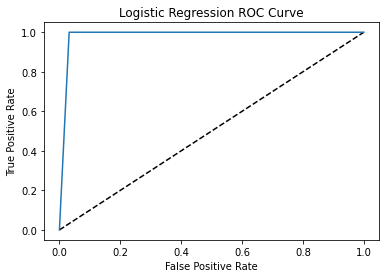

In [124]:
new_y_test = y_test == 1
fpr, tpr, thresholds = roc_curve(new_y_test, y_predict_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [125]:
print("Accuracy:", accuracy_score(y_test, y_predict_probs))
print("Precision:", precision_score(y_test, y_predict_probs))
print("Recall:", recall_score(y_test, y_predict_probs))
print("F1 Score:", f1_score(y_test, y_predict_probs))

Accuracy: 0.9781718963165075
Precision: 0.9357429718875502
Recall: 1.0
F1 Score: 0.9668049792531119
